

---

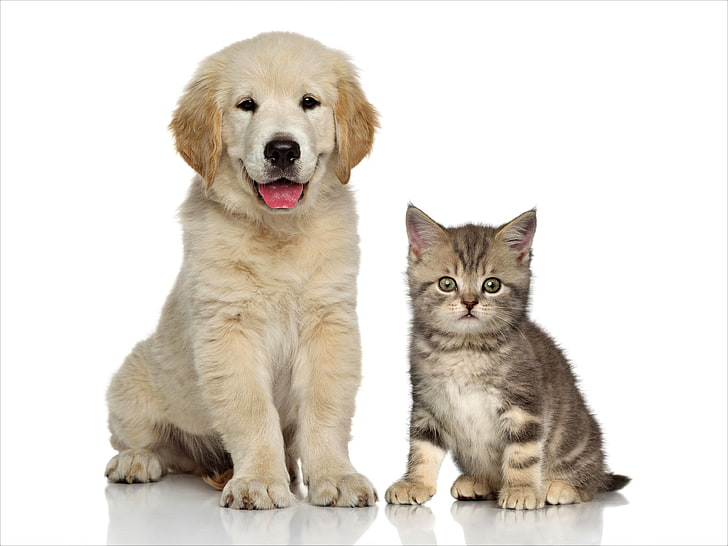


**Introduction:**

Image recognition plays various roles in our daily lives, ranging from identifying objects and humans to discerning specific items. In this task, our primary aim is to discern whether an image portrays a cat or a dog. While humans can easily distinguish between cats and dogs, this task can be laborious and demanding of constant attention. Machine learning presents a promising automated solution to mitigate this challenge

In [13]:
# import libraries
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

import cv2
from skimage.feature import hog

from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

# libraries for data plotting
import seaborn as sns
import matplotlib.pyplot as plt

# library for evaluation
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay

# libraries for ML algorithms

from random import randint
from random import seed
from sklearn.tree import DecisionTreeClassifier
RANDOM_SEED = 100

**Setting Up Drive and Files:**

*   Uploading a large dataset directly might not be feasible due to size constraints.
*   Hence, the most efficient method is to compress the dataset into a ZIP format before uploading it to Google Drive. Once uploaded, unzip the dataset to access its contents for further use.



In [14]:
import shutil
shutil.unpack_archive('/content/drive/MyDrive/data.zip')

In [15]:
data_folder = '/content/drive/MyDrive/data'

Importing the Train and Test CSV Files.

In [16]:
# load training data
df_train = pd.read_csv(os.path.join('train.csv'))

# summarise the details
print(f'Number of entries: {len(df_train)}')
df_train.head()

Number of entries: 10000


,id,label
0,1,cat
1,2,dog
2,3,cat
3,4,cat
4,5,cat



Verified for the presence of null values in the training dataset.

In [17]:
# load testing data
df_test = pd.read_csv(os.path.join('test.csv'))

# summarise the details
print(f'Number of entries: {len(df_test)}')
df_test.head()

Number of entries: 1000


,id
0,1
1,2
2,3
3,4
4,5


<Axes: xlabel='label', ylabel='count'>

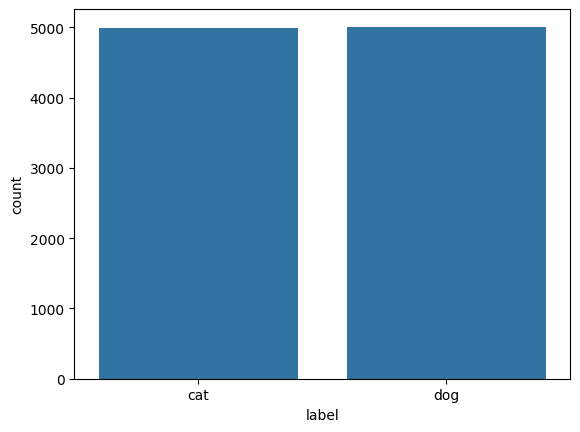

In [18]:
# Summarise label details in training data
sns.countplot(x=df_train['label'])

Upload the images from the dataset folder and conduct a verification process to ensure all images are successfully transferred. In case any images are missing during the upload, the system will promptly alert you. Upon completion, you will receive a report detailing the total number of images successfully uploaded or any failures encountered. Additionally, if resizing is deemed necessary, the system will perform this task automatically.

In [49]:
def load_images(ids, folder_path, dim=None):
  '''
  ids: list of image ids
  folder_path: path to image folder
  dim: dimensions to resize images (optional)
  '''
  images = []
  for id in tqdm(ids):
    image_path = os.path.join(folder_path, f'{id}.jpg')
    img = cv2.imread(image_path)

    # Resize if necessary
    if dim is not None:
      if img.shape[0] != dim[1] or img.shape[1] != dim[0]:
        img = cv2.resize(img, dim)
    images.append(img)
  return images


Tuple values representing height and weight, such as (300, 250), are commonly utilized in graphical or image-related scenarios.

Regarding image data, there are approximately 10,000 train images being uploaded for training purposes, along with around 1000 test images uploaded for testing purposes

In [50]:
base_dim = (200, 200)

# load train images
train_image_folder = os.path.join('train_images')
train_images = load_images(df_train['id'], train_image_folder, base_dim)
print(f'Number of training images loaded: {len(train_images)}')

# load test images
test_image_folder = os.path.join('test_images')
test_images = load_images(df_test['id'], test_image_folder, base_dim)
print(f'Number of testing images loaded: {len(test_images)}')

100%|██████████| 10000/10000 [00:34<00:00, 290.55it/s]


Number of training images loaded: 10000


100%|██████████| 1000/1000 [00:03<00:00, 323.35it/s]

Number of testing images loaded: 1000



Assessing the effectiveness of a classification model involves evaluating its accuracy and examining its performance through a confusion matrix. This process entails taking the actual labels, predicted labels, and class names as inputs, computing accuracy utilizing the scikit-learn library, generating a confusion matrix, and then visualizing it with the matplotlib library. This comprehensive analysis provides valuable insights into the model's ability to correctly classify data across various classes, aiding in fine-tuning and optimization efforts.

In [20]:
# method to calculate evaluation results
def evaluate(actuals, predictions, class_names):
  '''
  actuals: list of actual labels
  predictions: list of predicted labels
  class_names: list of classes used for the model/classification task
  '''
  # calculate accuracy
  accuracy = metrics.accuracy_score(actuals, predictions)
  print(f'Accuracy: {accuracy}')

  # plot confusion matrix
  confusion_matrix = metrics.confusion_matrix(actuals, predictions, labels=class_names)
  disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=class_names)
  disp.plot()
  plt.show()

In [60]:
# method to get image features
def get_features(images):
  features_list = []
  for img in images:
    # image preprocessing
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Resize image if necessary
    img_resized = cv2.resize(img_grayscaled, (64, 128))

    # feature extraction
    features, hog_image = hog(img_resized, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True)

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

In [62]:
# feature extraction
features_train = get_features(train_images)
print(features_train.shape)

(10000, 3780)


Image Id: 2386
Image Id: 7528
Image Id: 7453
Image Id: 2863
Image Id: 6439


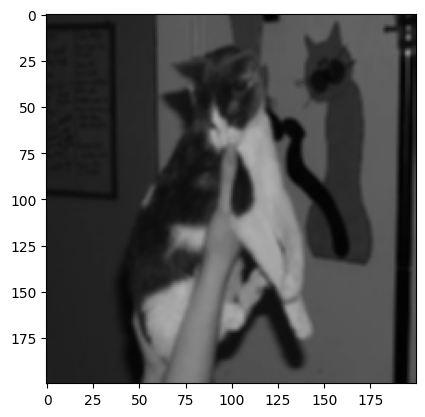

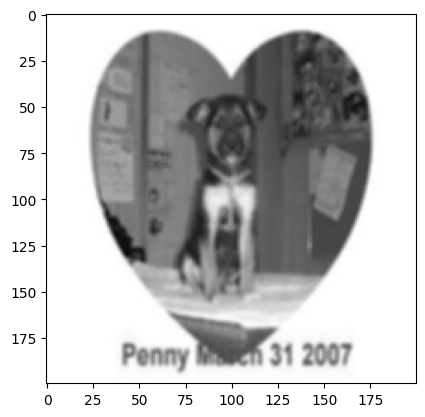

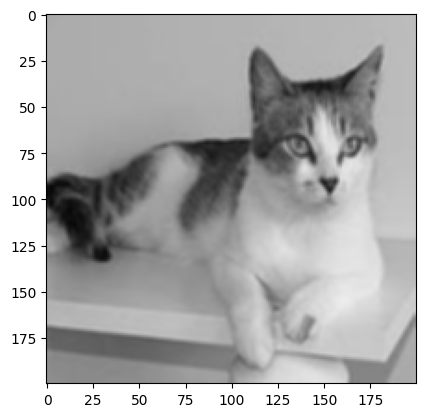

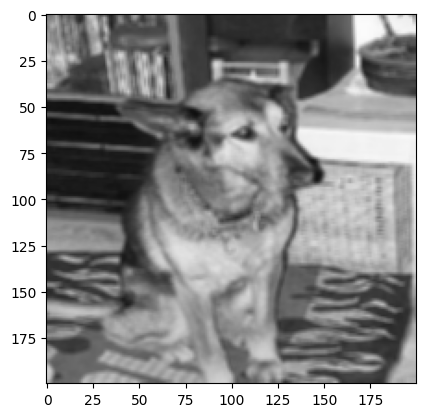

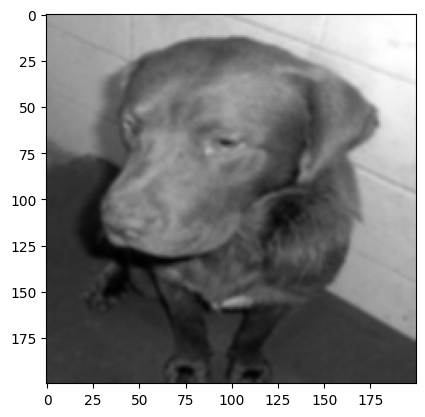

In [81]:
seed(RANDOM_SEED)
sample_images = []

# pick a random sample of images
for i in range(5):
  value = randint(0, len(train_images)-1)
  print(f'Image Id: {value}')
  sample_images.append(train_images[value])

# apply preprocessing and show output images
for img in sample_images:
  img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img_blurred = cv2.GaussianBlur(img_grayscaled,(3,3), 2)

  plt.imshow(cv2.cvtColor(img_blurred, cv2.COLOR_BGR2RGB))
  plt.show()

**Model One:**

In the realm of predictive modeling, logistic regression stands as a stalwart method for evaluating and predicting outcomes. Leveraging its versatility, we delve into its application through various analytical tools.


*   Confusion matrics.
*   Heat Map.


In [22]:
# method to train and predict using logistic regression
from sklearn.linear_model import LogisticRegression
def LogisticRegression_predictions(X_train, X_val, y_train, y_val):
  # build model
  Model_one = LogisticRegression(random_state=42)
  Model_one.fit(X_train, y_train)

  # Make predictions on test data
  y_pred = Model_one.predict(X_val)

  # evalution
  evaluate(y_val, y_pred, Model_one.classes_)

  return Model_one

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.686


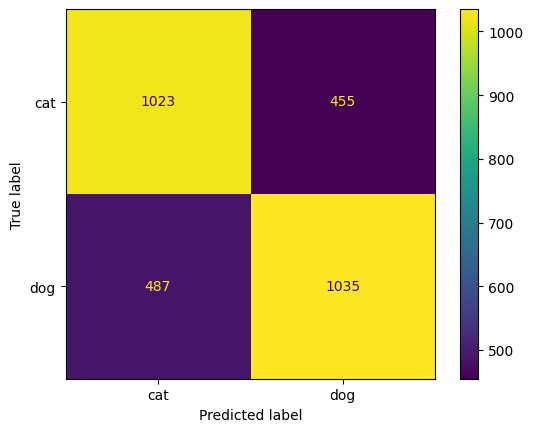

In [64]:
# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train, df_train['label'], test_size=0.3, random_state=RANDOM_SEED)

# train model
Model_one = LogisticRegression_predictions(X_train, X_val, y_train, y_val)

Using model one for training and validation of dataset and found that the accuracy of model is about 68 precentage.

**Model two:**

Using Decision Tree Classifier to evaluate and prediction.

Confusion Matrix.
Heat Map.

Decision trees are valuable in decision-making processes due to their ability to visually represent complex decision scenarios, aiding in understanding and interpreting the underlying logic. They are also useful in various fields such as finance, healthcare, and marketing for classification and prediction tasks, providing insights that guide strategic actions.






In [29]:
# method to train and predict using Decision tree
def Decision_tree_predictions(X_train, X_val, y_train, y_val):
  # build model
  Model_Second = DecisionTreeClassifier(random_state=42)
  Model_Second.fit(X_train, y_train)

  # Make predictions on test data
  y_pred = Model_Second.predict(X_val)

  # evalution
  evaluate(y_val, y_pred, Model_Second.classes_)

  return Model_Second

Accuracy: 0.584


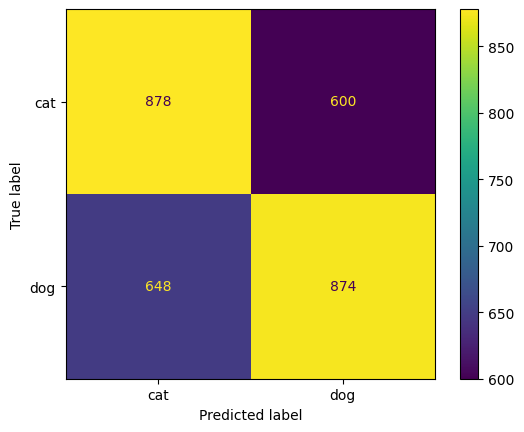

In [65]:
# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train, df_train['label'], test_size=0.3, random_state=RANDOM_SEED)

# train model
Model_Second = Decision_tree_predictions(X_train, X_val, y_train, y_val)

Using model one for training and validation of dataset and found that the accuracy of model is about 58 precentage.

**Model three:**

Utilizing a Random Forest Classifier for Evaluation and Prediction.

Random Forest is valuable for its robustness in handling complex datasets and its ability to mitigate overfitting, making it a powerful tool for predictive modeling in various domains such as finance, healthcare, and marketing. Its ensemble approach, combining multiple decision trees, enhances accuracy and provides insights into feature importance, aiding in data-driven decision-making processes.








In [44]:
# method to train and predict using RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
def RandomForestClassifier_predictions(X_train, X_val, y_train, y_val):
  # build model
  Model_third = RandomForestClassifier(random_state=42)
  Model_third.fit(X_train, y_train)

  # Evaluate model on validation set
  y_pred = Model_third.predict(X_val)


  # evalution
  evaluate(y_val, y_pred, Model_third.classes_)

  return Model_third

Accuracy: 0.6916666666666667


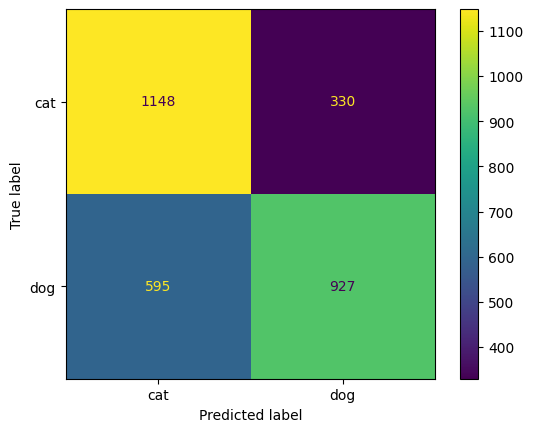

In [63]:
# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train, df_train['label'], test_size=0.3, random_state=RANDOM_SEED)

# train model
Model_third = RandomForestClassifier_predictions(X_train, X_val, y_train, y_val)

After employing the Random Forest Classifier (RFC) for training and validating our dataset, we observed that the accuracy of the model stands at approximately 69%. This initial model, labeled as "Model One," was trained and validated to assess its performance in classification tasks.

In [79]:
# feature extraction - test data
features_test = get_features(test_images)
print(features_test.shape)

# get model predictions
predictions = Model_third.predict(features_test)
df_test['Prediction'] = predictions
df_test.to_csv('Prediction_result.csv', index=False)
print(predictions)

(1000, 3780)
['dog' 'cat' 'cat' 'cat' 'dog' 'dog' 'dog' 'dog' 'cat' 'dog' 'dog' 'dog'
 'dog' 'dog' 'dog' 'cat' 'cat' 'dog' 'cat' 'cat' 'dog' 'dog' 'cat' 'cat'
 'cat' 'cat' 'dog' 'dog' 'dog' 'dog' 'cat' 'dog' 'dog' 'cat' 'cat' 'cat'
 'dog' 'dog' 'dog' 'cat' 'dog' 'dog' 'cat' 'dog' 'cat' 'cat' 'dog' 'cat'
 'cat' 'dog' 'cat' 'dog' 'cat' 'dog' 'dog' 'dog' 'cat' 'cat' 'cat' 'cat'
 'dog' 'dog' 'cat' 'cat' 'dog' 'dog' 'cat' 'dog' 'dog' 'cat' 'cat' 'dog'
 'cat' 'cat' 'cat' 'cat' 'dog' 'dog' 'dog' 'dog' 'dog' 'dog' 'cat' 'cat'
 'dog' 'cat' 'dog' 'cat' 'dog' 'cat' 'cat' 'dog' 'dog' 'dog' 'cat' 'cat'
 'cat' 'dog' 'dog' 'cat' 'cat' 'dog' 'cat' 'dog' 'dog' 'dog' 'dog' 'cat'
 'dog' 'dog' 'dog' 'dog' 'dog' 'dog' 'cat' 'cat' 'cat' 'dog' 'dog' 'dog'
 'cat' 'dog' 'cat' 'dog' 'cat' 'cat' 'dog' 'cat' 'dog' 'cat' 'dog' 'cat'
 'dog' 'cat' 'dog' 'cat' 'cat' 'dog' 'dog' 'dog' 'cat' 'cat' 'cat' 'dog'
 'cat' 'cat' 'dog' 'dog' 'cat' 'cat' 'dog' 'cat' 'dog' 'dog' 'cat' 'dog'
 'dog' 'dog' 'dog' 'cat' 'dog' 'dog' '

**Model four:**

Utilizing GaussianNB Classifier for Evaluation and Prediction.

Employing the GaussianNB Classifier to assess and predict outcomes.


In [71]:
# method to train and predict using GaussianNB
from sklearn.naive_bayes import GaussianNB
def GaussianNB_predictions(X_train, X_val, y_train, y_val):
  # build model
  Model_forth = GaussianNB()
  Model_forth.fit(X_train, y_train)

  # Make predictions on test data
  y_pred = Model_forth.predict(X_val)

  # evalution
  evaluate(y_val, y_pred, Model_forth.classes_)

  return Model_forth

Accuracy: 0.6766666666666666


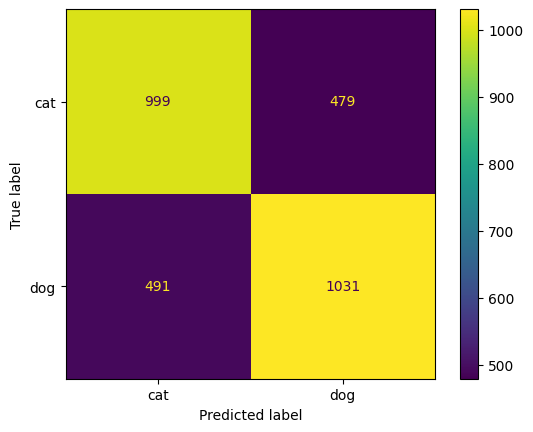

In [74]:
# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train, df_train['label'], test_size=0.3, random_state=RANDOM_SEED)

# train model
Model_forth = GaussianNB_predictions(X_train, X_val, y_train, y_val)

After utilizing Model One for training and validating the dataset, it was observed that the accuracy of the model stands at approximately 67%.

**Conclusion:**

After evaluating several models, the RandomForestClassifier emerged as the top performer, boasting an accuracy of approximately 69.16%. Following closely behind, logistic regression and GaussianNB exhibited robust accuracies, achieving around 68.6% and 67.7%, respectively. However, the Decision Tree Classifier lagged behind with a comparatively lower accuracy of 58.4%.